In [3]:
# %load house.py
#!/usr/bin/env python3

#####################################################
#                                                   #
#    U.S. HOUSE STATISTICAL PREDICTIONS             #
#    CORY McCARTAN                                  #
#                                                   #
#####################################################


import math
import re
import pickle
import os
import argparse
import json
from datetime import date, datetime, timedelta
import time
from urllib.request import urlopen as fetch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

from bs4 import BeautifulSoup
import pollster
pollster = pollster.Api()

import pandas as pd
import numpy as np
from pystan import StanModel 
import us

import priors

In [7]:
def get_polling_data(year=2018, max_date=None):
    nov_1 = date(year, 11, 1)
    election_day = nov_1 + timedelta(days=(1 - nov_1.weekday() + 7) % 7)

    polls = pollster.questions_slug_poll_responses_clean_tsv_get(f"{str(year)[-2:]}-US-House")
    polls = polls[polls.sample_subpopulation.isin(["Likely Voters", "Registered Voters"])]
    polls.rename(columns={"observations": "n_resp"}, inplace=True)

    if max_date is not None:
        polls = polls[polls.end_date <= max_date]

    polls["n_dem"] = polls.Democrat / (polls.Democrat + polls.Republican) * polls.n_resp
    polls.dropna(subset=["n_dem"], inplace=True)
    polls.n_dem = polls.n_dem.astype("int")
    polls.n_resp = polls.n_resp.astype("int")

    polls["pollster"] = pd.factorize(polls.survey_house)[0] + 1
    weeks = (election_day - polls.start_date).apply(lambda x: int(x.days / 7))
    months = (election_day - polls.start_date).apply(lambda x: int(x.days / 30.4375))
    n_weeks = weeks.max() + 1
    n_months = months.max() + 1
    polls["week"] = n_weeks - weeks
    polls["month"] = n_months - months

    polls.drop(["Democrat", "Republican", "Other", "Undecided", "survey_house", "start_date",
                "end_date", "sample_subpopulation", "mode", "partisanship", "partisan_affiliation",
                "poll_slug", "question_text", "margin_of_error"], axis=1, inplace=True)

    return polls, n_weeks, n_months

def find_not_running(year):
    page = fetch(f"https://en.wikipedia.org/wiki/United_States_House_of_Representatives_elections,_{year}")
    soup = BeautifulSoup(page, "lxml")
    # find the section that mentions retiring incumbents
    incumbents = soup.find("span", class_="mw-headline", string=re.compile("incumbent", re.I)).parent
    not_running = []
    # there is a list for each party
    for l in incumbents.find_next_siblings("ol"):
        for item in l.find_all("li"):
            # each item is like 'Arizona 1: John Smith.' We extract the state and district # 
            state, district = item.get_text().split(":")[0].split("\xa0")
            district = 0 if district.lower() == "at-large" else int(district)
            not_running.append(f"{name_to_abbr(state)}-{district:02}")

    return not_running

def get_incumbency():
    data = []
    
    page = fetch("https://en.wikipedia.org/wiki/Current_members_of_the_United_States_House_of_Representatives")
    soup = BeautifulSoup(page, "lxml")
    
    heading = soup.find("span", id="Voting_members_by_state").parent
    table = heading.find_next_sibling("table")
   
    first = True
    for row in table.find_all("tr"):
        # skip first row (headings)
        if first:
            first = False
            continue
            
        district, _, _, party, *_ = [c.text for c in row.find_all("td")]
        state, district = re.split(' (?=at large|\d)', district.lower())
        district = 0 if district == "at large" else int(district)
        party = 1 if party == "Democratic" else -1 if party == "Republican" else 0
        
        data.append({
            "district": f"{name_to_abbr(state)}-{district:02}",
            "incumbent": party
        })
    
    return pd.DataFrame(data).sort_values("district").set_index("district", drop=False)

def name_to_abbr(name):
    return us.states.lookup(name).abbr


def get_args():
    parser = argparse.ArgumentParser(description="Forecast 2018 U.S. House races.",
            formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--dry", action="store_true",
            help="Dry run, no results saved.")
    parser.add_argument("--date", type=date_type, default=datetime.now(),
            help="Date to model. Polls after this date are discarded.")
    parser.add_argument("--race_n", type=int, nargs="?", default=20_000,
            help="MCMC iterations for individual races.")
    parser.add_argument("--nat_n", type=int, nargs="?", default=3000,
            help="MCMC iterations for national poll aggregation.")
    parser.add_argument("--recompile", action="store_true",
            help="Force recompile of STAN model.")
    parser.add_argument("--model_dir", type=str, nargs="?", default="models",
            help="Directory in which models are stored.")
    parser.add_argument("--output_file", type=str, nargs="?", default="docs/data/output.json",
            help="File in which to output results.")
    parser.add_argument("--history_file", type=str, nargs="?", default="docs/data/history.json",
            help="File in which to store model history.")

    return parser.parse_args("")

# Date format checker for argparse
def date_type(arg_date_str):
    try:
        return datetime.strptime(arg_date_str, "%Y-%m-%d")
    except ValueError:
        msg = ("Dates must be given as YYYY-MM-DD.  The provided date, " 
            f"\"{arg_date_str}\", was not valid.")
        raise argparse.ArgumentTypeError(msg)

In [10]:
args = get_args()

election_day = datetime(2018, 11, 6)
current_seats = 194

print("===========================================")
print("  2018 U.S. HOUSE PREDICTIONS              ")
print("===========================================")
print()

#################################
# Load prior models             #
#################################
nat_prior = priors.get_national_prior(model_dir=args.model_dir)
race_prior = priors.get_race_prior(model_dir=args.model_dir)
bias_prior = priors.get_bias_prior(recalculate=True, model_dir=args.model_dir)


#################################
# Organize data for prediction  #
#################################

approvals = priors.get_approvals_data()
cd_vote = priors.get_pvi_data()

polls, n_weeks, n_months = get_polling_data(max_date = args.date)

if args.date >= datetime(2018, 6, 1):
    appr_slice = approvals[(approvals.date > date(2018, 1, 1))
                            & (approvals.date < date(2018, 6, 1))]
else: # use last six months
    ago = args.date - timedelta(6 * 365/12)
    appr_slice = approvals[(approvals.date > ago) & (approvals.date < args.date)]

nat_prior_data = [{
    "APPR": appr_slice.approval.mean(),
    "INC": -1,
    "PRES": -1,
    "MID": 1,
}]
nat_prediction = nat_prior.predict(nat_prior_data)[0]

# create covariance matrix for national polling error
sigma_cov = np.full((n_months, n_months), 0.0)ba
np.fill_diagonal(sigma_cov, bias_prior.mse_resid / 100**2)
diag = np.arange(0, n_months - 1)
sigma_cov[diag + 1, diag] = bias_prior.step_var
sigma_cov[diag, diag+1] = bias_prior.step_var

mcmc_data = {
    "R": 435,
    "W": n_weeks,
    "M": n_months,
    "N": len(polls),
    "P": max(polls.pollster),
    "w": polls.week.values,
    "m": polls.month.values,
    "n_resp": polls.n_resp.values,
    "n_dem": polls.n_dem.values,
    "p": polls.pollster.values,
    "alpha_n_prior": bias_prior.predict({"months": range(n_months-1, -1, -1)}).values / 100,
    "sigma_n_prior": sigma_cov,
    "mu_prior": nat_prediction / 100,
    "mu_mse": math.sqrt(nat_prior.mse_resid) / 100,
}


#################################
# Compile and run STAN model    #
#################################

filename = "house_stan.pkl"
path = os.path.join(args.model_dir, filename)

if os.path.isfile(path) and not args.recompile:
    with open(path, "rb") as f:
        model = pickle.load(f)
else:
    model = StanModel(file="house.stan")
    with open(path, "wb") as f:
        pickle.dump(model, f)


fit = model.sampling(data=mcmc_data, chains=3, iter=args.nat_n, 
        warmup=args.nat_n // 3)


#################################
# Extract results               #
#################################

mu_samples = fit.extract("mu")["mu"]
y = 100 * np.mean(mu_samples, axis=0)
err_y = 100 * np.std(mu_samples, axis=0)
weeks = pd.date_range(end=election_day, periods=n_weeks, freq="W")
weeks = weeks.strftime("%Y-%m-%d")


alpha_samples = fit.extract("alpha_n")["alpha_n"]
alpha = 100 * np.mean(alpha_samples, axis=0)
err_alpha = 2 * 100 * np.std(alpha_samples, axis=0)

  2018 U.S. HOUSE PREDICTIONS              



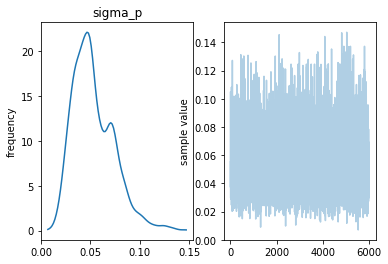

In [24]:
fit.plot("sigma_p")

In [19]:
#################################
# Predict individual races      #
#################################

incumbents = get_incumbency()
not_running = find_not_running(2018)

race_prior_data = []
races = incumbents.district.unique()
incumbent_series = []
for race in races:
    incumbent_series.append(incumbents.loc[race].incumbent)
    race_prior_data.append({ 
        "NAT": y[-1],
        "INC": 0 if race in not_running else incumbents.loc[race].incumbent,
        "PVI": cd_vote.loc[race].pvi_2018,
        "ADJ": cd_vote.loc[race].pres_margin_16,
        "MID": 1,
        "PRES": -1,
    })

race_predictions = race_prior.predict(race_prior_data).values / 100

# add in variance from national model
addl_var = (err_y[-1] / 100)**2
cov_matrix = np.full((435, 435), race_prior.mse_resid/100**2 + addl_var)
np.fill_diagonal(cov_matrix, race_prior.dist_var/100**2 + addl_var)

results = np.random.multivariate_normal(race_predictions, cov_matrix, args.race_n)

expected = results.mean(axis=0)
expected_std = results.std(axis=0)
prob_district = np.mean((np.sign(results) + 1) / 2, axis=0)
seats = np.sum((np.sign(results) + 1) / 2, axis=1).astype(int)
seats_hist = np.bincount(seats, minlength=436) / len(seats)
prob = np.mean(seats >= 218)
gain = np.mean(seats) - current_seats

print()
print(f"National Prediction: {'D' if y[-1] >= 0 else 'R'}+{abs(y[-1]):.1f}%")
print(f"Democrats have a {prob:.0%} chance of retaking the House.")
print(f"They are expected to {'gain' if gain > 0 else 'lose'} {abs(gain):.0f} seats.")
print()


National Prediction: D+6.5%
Democrats have a 32% chance of retaking the House.
They are expected to gain 22 seats.



In [8]:
#################################
# Output predictions            #
#################################

if args.dry: 
    exit(0)

timestamp = int(1000 * args.date.timestamp())

district_data = pd.DataFrame({
        "margin": expected,
        "std": expected_std,
        "prob": prob_district,
        "district": races,
        "incumbent": incumbent_series,
    })
nat_data = pd.DataFrame({
        "margin": y,
        "std": err_y,
        "weeks": weeks,
    })
output_data = {
        "time": timestamp,
        "prob": prob,
        "gain": gain,
        "seats": seats.mean(),
        "seats_std": seats.std(),
        "seats_dist": seats_hist.tolist(),
        "districts": district_data.to_dict("records"),
        "generic": nat_data.to_dict("records"),
        "scenarios": {
            "dem_gain": sum(seats > current_seats) / len(seats),
            "gop_gain": sum(seats < current_seats) / len(seats),
            }
        }

with open(args.output_file, "w") as f:
    json.dump(output_data, f)
    print(f"Data written to {args.output_file}.")

# History
if os.path.isfile(args.history_file):
    with open(args.history_file, "rb") as f:
        history = json.load(f)
else:
    history = []

history.append({
        "time": timestamp,
        "prob": prob,
        "gain": gain,
    });
with open(args.history_file, "w") as f:
    json.dump(history, f)
    print(f"Run logged to {args.history_file}.")

  2018 U.S. HOUSE PREDICTIONS              



Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/Cel

KeyboardInterrupt: 